In [646]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy
import seaborn as sns
import sklearn
from helpers import *

In [2]:
DATA_FOLDER = "../Data/"
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID":parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genres": parse_list
    },
)

In [3]:
actors = actors_load.copy()
movies = movies_load.copy()

In [4]:
actors_exp = explode_on_movies(actors)

In [496]:
# Merge actors_exp DataFrame with selected columns from movies DataFrame and sort chronologically
actors_movies = actors_exp.merge(
    movies[["fbID", "genres", "releaseMonth", "releaseYear"]], how="left", on="fbID"
)
actors_movies_sort = actors_movies.sort_values(
    by=["fbActorID", "ageAtMovieRelease", "releaseYear", "releaseMonth"]
)

# Filter actors with at least 20 movies
actors_min_movies = actors_movies_sort.query("numMovies >= 20")

# Remove rows where both ageAtMovieRelease and releaseYear are NaN and where genres is NaN
actors_filter = actors_min_movies[
    ~(actors_min_movies.ageAtMovieRelease.isna() & actors_min_movies.releaseYear.isna())
    & ~actors_min_movies.genres.isna()
].copy()

# Create a new column "genresLen" representing the number of the genres for each movie
actors_filter["genresLen"] = actors_filter.genres.apply(lambda x: len(x))

# Create a new column "LastMovie" indicating whether it's the last movie for each actor
actors_filter["LastMovie"] = np.array(
    [*(actors_filter.fbActorID[1:].values != actors_filter.fbActorID.values[:-1]), True]
)

# Get list of genres in order of occurrences
genreslist = actors_filter.genres.explode().value_counts().index

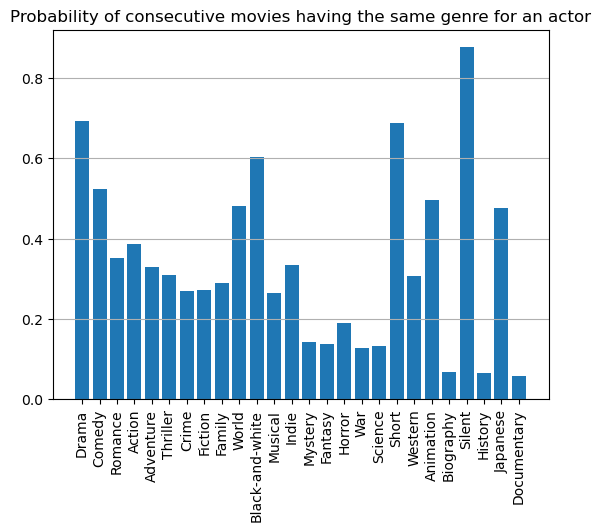

In [497]:
# Create a new DataFrame 'df_genres' containing genre columns and reset index to be able to iterate
df_genres = actors_filter[["genres", "genresLen", "LastMovie"]].reset_index(
    drop=True
)

# Count the occurrences of genres in movies that are not the last for each actor
genres_counts = df_genres[~df_genres["LastMovie"]].genres.explode().value_counts()

# Create a dictionary mapping genres to their corresponding index based on their order of occurrences
index_genres = dict(zip(genres_counts.index, np.arange(len(genreslist))))

# Initialize an array to track the number of times each genre is kept by an actor for two consecutive movies
genre_kept = np.zeros(len(genreslist))

for index, row in df_genres.iterrows():
    # Check if it's not the last movie for the actor
    if not row["LastMovie"]:
        # Find the intersection of genres between the current and next movie
        genre_intersection = row["genres"].intersection(
            df_genres["genres"].iloc[index + 1]
        )
        # If there is an intersection, update genre_kept array
        if len(genre_intersection) != 0:
            for genre in genre_intersection:
                genre_kept[index_genres[genre]] += 1

# Plot a bar chart showing the proportion of each genre kept
plt.figure()
plt.bar(genreslist, genre_kept / genres_counts)
plt.xticks(rotation=90)
plt.title("Probability of consecutive movies having the same genre for an actor")
plt.grid(axis="y")

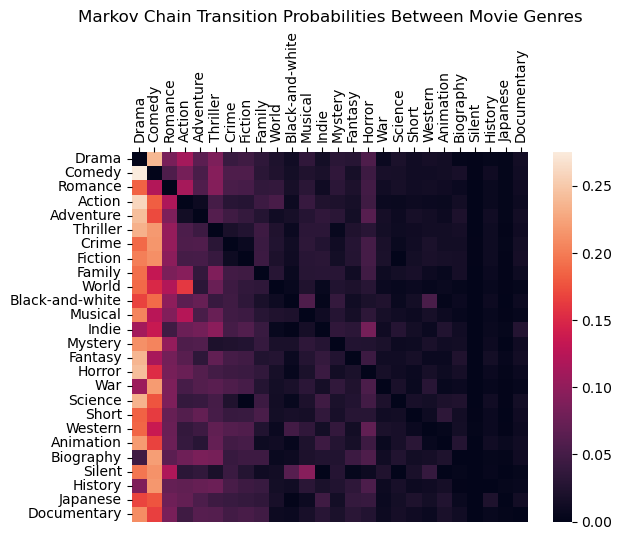

In [498]:
# Initialize a square matrix M to represent the Markov chain transition probabilities
M = np.zeros((len(index_genres), len(index_genres)))

# Iterate through rows of df_genres
for index, row in df_genres.iterrows():
    # Check if it's not the last movie for the actor
    if not row["LastMovie"]:
        # Find the intersection of genres between the current and next movie
        genre_intersection = row["genres"].intersection(df_genres["genres"].iloc[index + 1])
        # If there is no intersection, update the Markov chain transition matrix
        if len(genre_intersection) == 0:
            for genres_i in row["genres"]:
                for genres_j in df_genres["genres"].iloc[index + 1]:
                    M[index_genres[genres_i], index_genres[genres_j]] += 1 / (row["genresLen"] * df_genres["genresLen"].iloc[index + 1])

# Normalize to represent a Markov chain
M = np.divide(M, M.sum(axis=1)[:, np.newaxis])

# Plot a heatmap of the Markov chain transition matrix
heatmap_ax = sns.heatmap(
    M,
    xticklabels=genreslist,
    yticklabels=genreslist,
)
heatmap_ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.title("Markov Chain Transition Probabilities Between Movie Genres");

In [ ]:
actors_min_movies

In [503]:
# Filter out rows where genres are not NaN and count genres for each movies
actors_genres = actors_min_movies[~actors_min_movies.genres.isna()].copy()
actors_genres["genresLen"] = actors_genres.genres.apply(lambda x: len(x))

# Explode the genres column to create separate rows for each genre
exploded_actors_genres = actors_genres.explode("genres")

# Create dummy variables for genres using one-hot encoding
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "genres", "genresLen", "fbID"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

# Group by fbActorID and aggregate data, summing up occurrences of each genre
actor_genre_counts = (
    genre_dummies
    .groupby("fbActorID")
    .agg({"fbID": lambda x: np.unique(x), **{genre: "sum" for genre in genreslist}})
)

# Calculate the number of movies with genre for each actor 
actor_genre_counts["numMoviesWithGenre"] = actor_genre_counts.fbID.apply(lambda x: len(x))

# Calculate the proportion of each genre for each actor
actor_genre_proportion = actor_genre_counts[genreslist].div(
    actor_genre_counts["numMoviesWithGenre"], axis=0
)

actor_genre_proportion

,Drama,Comedy,Romance,Action,Adventure,Thriller,Crime,Fiction,Family,World,...,War,Science,Short,Western,Animation,Biography,Silent,History,Japanese,Documentary
fbActorID,,,,,,,,,,,,,,,,,,,,,
/m/010xjr,0.807692,0.134615,0.230769,0.423077,0.538462,0.192308,0.230769,0.230769,0.115385,0.096154,...,0.192308,0.038462,0.000000,0.153846,0.038462,0.057692,0.00,0.076923,0.000000,0.000000
/m/0112yl,0.875000,0.187500,0.083333,0.500000,0.458333,0.166667,0.166667,0.208333,0.000000,0.541667,...,0.125000,0.000000,0.000000,0.020833,0.000000,0.020833,0.00,0.083333,0.750000,0.000000
/m/011_3s,0.407407,0.888889,0.148148,0.074074,0.148148,0.111111,0.148148,0.148148,0.296296,0.037037,...,0.037037,0.037037,0.000000,0.000000,0.111111,0.000000,0.00,0.037037,0.037037,0.000000
/m/011_nf,0.750000,0.333333,0.416667,0.111111,0.194444,0.055556,0.166667,0.111111,0.083333,0.000000,...,0.000000,0.000000,0.000000,0.083333,0.000000,0.027778,0.25,0.027778,0.000000,0.000000
/m/011_pk,0.843750,0.250000,0.343750,0.250000,0.156250,0.187500,0.500000,0.406250,0.000000,0.000000,...,0.062500,0.000000,0.000000,0.031250,0.000000,0.031250,0.00,0.031250,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/m/0tj9,0.772973,0.302703,0.356757,0.459459,0.200000,0.156757,0.167568,0.118919,0.151351,0.621622,...,0.016216,0.005405,0.005405,0.005405,0.000000,0.005405,0.00,0.016216,0.000000,0.005405
/m/0ywqc,0.684685,0.306306,0.135135,0.288288,0.243243,0.405405,0.279279,0.306306,0.036036,0.045045,...,0.135135,0.099099,0.009009,0.018018,0.018018,0.063063,0.00,0.054054,0.027027,0.036036
/m/0z05l,0.777778,0.370370,0.185185,0.259259,0.518519,0.222222,0.185185,0.259259,0.185185,0.000000,...,0.074074,0.074074,0.000000,0.259259,0.000000,0.148148,0.00,0.037037,0.037037,0.000000


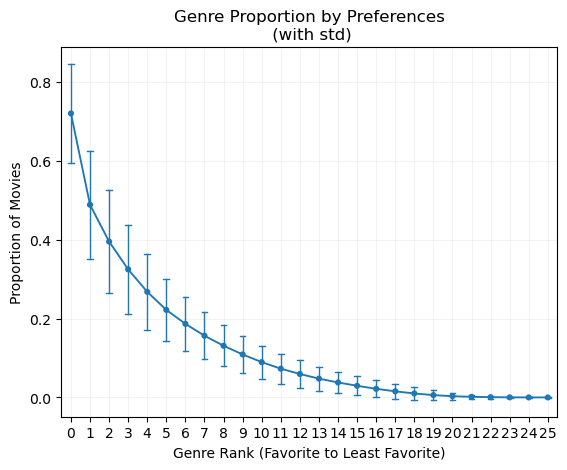

In [534]:
# Sort genres for each actor from favorite to least favorite
actor_genre_proportion_arr = actor_genre_proportion.to_numpy()
genre_favorites_prop=np.sort(actor_genre_proportion_arr, axis=1)[:, ::-1]

sns.pointplot(
    data=genre_favorites_prop,
    errorbar="sd",  # Show error bars based on standard deviation
    scale=0.5,
    capsize=0.3,
    errwidth=1,
)
plt.title("Genre Proportion by Preferences\n (with std)")
plt.xlabel("Genre Rank (Favorite to Least Favorite)")
plt.ylabel("Proportion of Movies")
plt.grid(alpha=0.15)
plt.show()

In [651]:

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

In [578]:
test = (actor_genre_proportion_arr- actor_genre_proportion_arr.mean(axis=0))/ actor_genre_proportion_arr.std(axis=0)

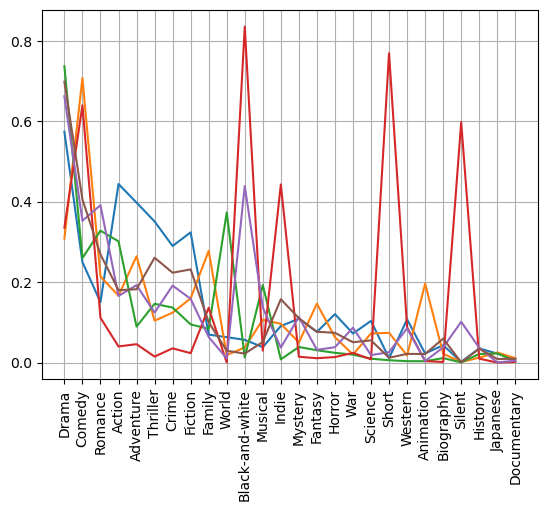

In [694]:
kmeans = KMeans(n_clusters=6, n_init=10).fit(actor_genre_proportion_arr)

# plt.figure(figsize=(20,10))
# for i in range(len(kmeans.cluster_centers_)):
#     plt.subplot(len(kmeans.cluster_centers_),1, i+1)
#     plt.plot(kmeans.cluster_centers_.T[:,i]*actor_genre_proportion_arr.std(axis=0) + actor_genre_proportion_arr.mean(axis=0))
#     plt.xticks(np.arange(len(genreslist)),genreslist, rotation=90)
#     #plt.legend(labels=np.arange(len(kmeans.cluster_centers_)))
plt.plot(kmeans.cluster_centers_.T);
plt.xticks(np.arange(len(genreslist)),genreslist, rotation=90);
plt.grid()

In [580]:
np.unique(kmeans.predict(test), return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([ 805,  112,  826, 1135,  888,  103]))

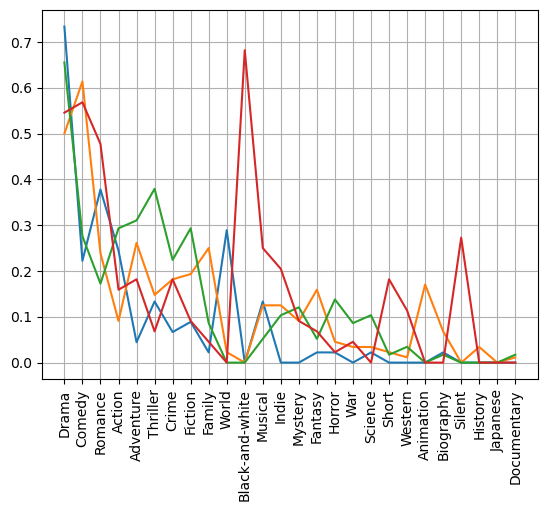

In [566]:
from scipy.spatial.distance import cdist
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate the distance between each data point and the cluster centers
distances = cdist(actor_genre_proportion_arr, cluster_centers)

# Find the index of the data point closest to each cluster center
cluster_medoids = np.argmin(distances, axis=0)

# Get the profile sequences of the cluster medoids
medoid_profile_sequences = actor_genre_proportion_arr[cluster_medoids]

plt.plot(medoid_profile_sequences.T);
plt.xticks(np.arange(len(genreslist)),genreslist, rotation=90);
plt.grid()

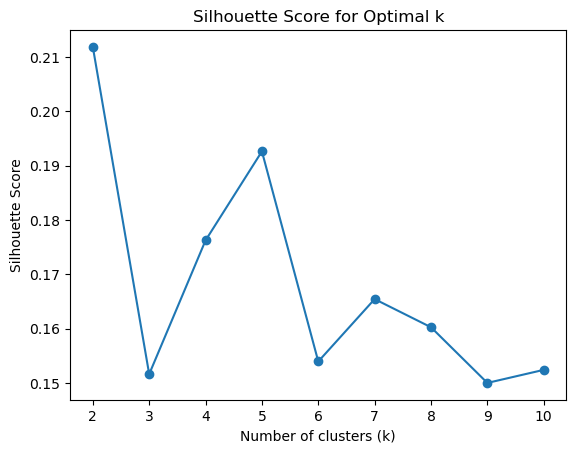

In [411]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init=20)
    kmeans.fit(arr)
    silhouette_scores.append(silhouette_score(actor_genre_proportion_arr, kmeans.labels_))

# Plotting the Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [675]:
agg_clu = AgglomerativeClustering(n_clusters=5)
clustering = agg_clu.fit(actor_genre_proportion_arr)
np.unique(clustering.labels_, return_counts=True)


(array([0, 1, 2, 3, 4]), array([1414,  521,  670, 1182,   82]))

In [676]:
agg_clu

AgglomerativeClustering(n_clusters=5)

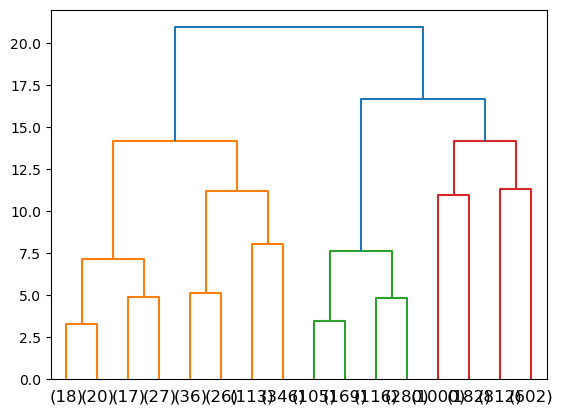

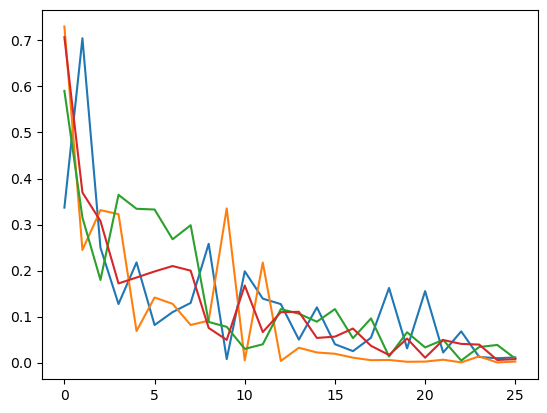

In [699]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Assume you have an array 'actor_genre_proportion_arr'
# Calculate the linkage matrix
linkage_matrix = linkage(actor_genre_proportion_arr, method='ward')  # You can use different linkage methods

# Plot the dendrogram
dendrogram(linkage_matrix, truncate_mode="level", p=3)

# Determine clusters based on a distance threshold or the number of clusters
threshold = 12  # You can adjust this threshold according to your data
clusters = fcluster(linkage_matrix, criterion='maxclust', t=4)

# Calculate cluster means
unique_clusters = np.unique(clusters)
cluster_means = np.zeros((len(unique_clusters), actor_genre_proportion_arr.shape[1]))

for i, cluster in enumerate(unique_clusters):
    cluster_means[i, :] = np.mean(actor_genre_proportion_arr[clusters == cluster, :], axis=0)

plt.figure()
plt.plot(cluster_means.T)
# Show the plot
plt.show()


array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

# Normalisé

Text(0, 0.5, 'Frequency')

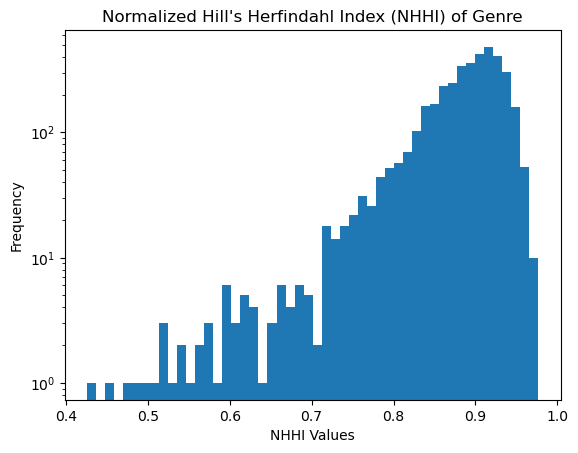

In [607]:
# Creating dummy variables for genres and counting occurrences for each actor and movie
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "genres", "genresLen", "fbID"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

# Normalize genre occurrences by dividing each genre count by the total number of genres in movies
genre_dummies[genreslist] = (1 * genre_dummies[genreslist]).div(
    genre_dummies["genresLen"], axis=0
)

# Group by actor and aggregate data, summing up occurrences of each genre
actor_genre_counts = genre_dummies.groupby("fbActorID").agg(
    {"fbID": lambda x: np.unique(x), **{genre: "sum" for genre in genreslist}}
)

# Calculate the number of movies with genres for each actor 
actor_genre_counts["numMoviesWithGenre"] = actor_genre_counts.fbID.apply(lambda x: len(x))

# Calculate the percentage of each genre for each actor 
actor_genre_percentage = actor_genre_counts[genreslist].div(
    actor_genre_counts["numMoviesWithGenre"], axis=0
)

# Convert the actor_genre_percentage DataFrame to numpy arrays for further calculations
genres_perc = actor_genre_percentage.to_numpy()
num_film = actor_genre_counts["numMoviesWithGenre"].to_numpy()

# Calculate Normalized Hill's Herfindahl Index (NHHI) to measure diversity in genre preferences
NHHI = 1 - ((genres_perc**2).sum(axis=1) - 1 / num_film) / (1 - 1 / num_film)

plt.hist(NHHI, bins=50)
plt.yscale("log")
plt.title("Normalized Hill's Herfindahl Index (NHHI) of Genre")
plt.xlabel("NHHI Values")
plt.ylabel("Frequency")

In [725]:
(movies.averageRating.isna()).sum()/len(movies)

0.4411707054124911

/Users/vacosta/anaconda3/envs/ADA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/vacosta/anaconda3/envs/ADA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/vacosta/anaconda3/envs/ADA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/vacosta/anaconda3/envs/ADA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

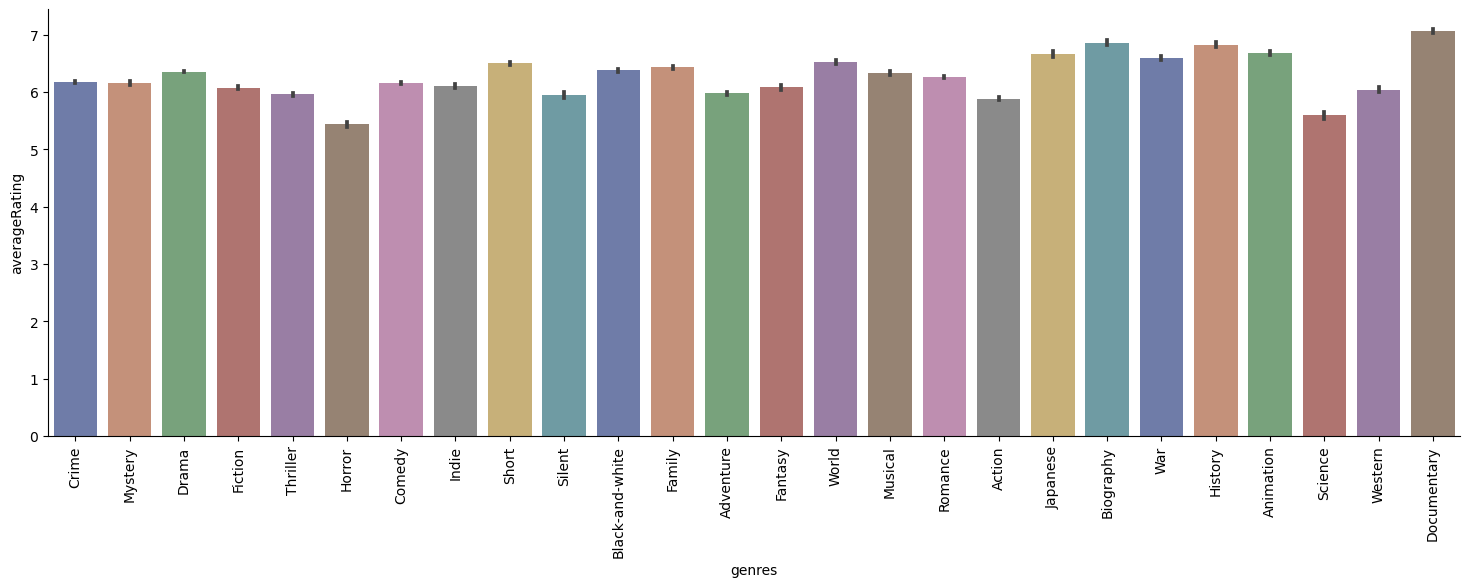

In [731]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(
    data=movies.explode("genres"), kind="bar",
    x="genres", y="averageRating",
    errorbar="ci", palette="dark", alpha=.6,aspect=3,  # Increase the height value
)
plt.xticks(rotation=90)
plt.show()


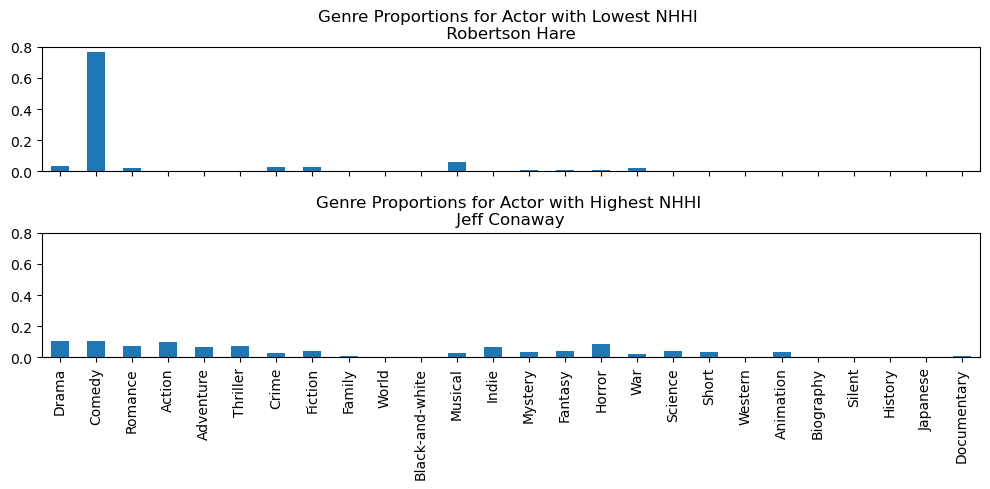

In [648]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Plot genre proportions for the actor with the lowest NHHI value
actor_genre_percentage.iloc[np.argmin(NHHI)].plot(kind="bar", ax=ax1)
ax1.set_ylim(0, 0.8)
ax1.set_title(
    f"Genre Proportions for Actor with Lowest NHHI \n {actors[actors['fbActorID']==actor_genre_percentage.iloc[np.argmin(NHHI)].name].actorName.item()} "
)

# Plot genre proportions for the actor with the highest NHHI value
actor_genre_percentage.iloc[np.argmax(NHHI)].plot(kind="bar", ax=ax2)
ax2.set_ylim(0, 0.8)
ax2.set_title(
    f"Genre Proportions for Actor with Highest NHHI \n {actors[actors['fbActorID']==actor_genre_percentage.iloc[np.argmax(NHHI)].name].actorName.item()} "
)
ax2.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

Drama PearsonRResult(statistic=-0.4445263383329073, pvalue=3.943489762336163e-187)
Comedy PearsonRResult(statistic=-0.22308136244191268, pvalue=7.828282996175352e-45)
Romance PearsonRResult(statistic=-0.10039227315575369, pvalue=3.891305463747206e-10)
Action PearsonRResult(statistic=0.056014635061944505, pvalue=0.0004906798779350714)
Adventure PearsonRResult(statistic=0.4312414494163676, pvalue=4.978358114104896e-175)
Thriller PearsonRResult(statistic=0.3769411783429046, pvalue=7.016101941224877e-131)
Crime PearsonRResult(statistic=0.380308161475424, pvalue=2.2029047349371442e-133)
Fiction PearsonRResult(statistic=0.4379629051843205, pvalue=4.385810391433936e-181)
Family PearsonRResult(statistic=-0.04100595209454599, pvalue=0.010745389127773605)
World PearsonRResult(statistic=-0.1323370794585692, pvalue=1.3940038121023509e-16)
Black-and-white PearsonRResult(statistic=-0.011550289691127563, pvalue=0.472612597477737)
Musical PearsonRResult(statistic=-0.17170774968583724, pvalue=5.4944392

/var/folders/zb/93_wdkq15c59q4mk_nb7d79c0000gn/T/ipykernel_61639/1481796474.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


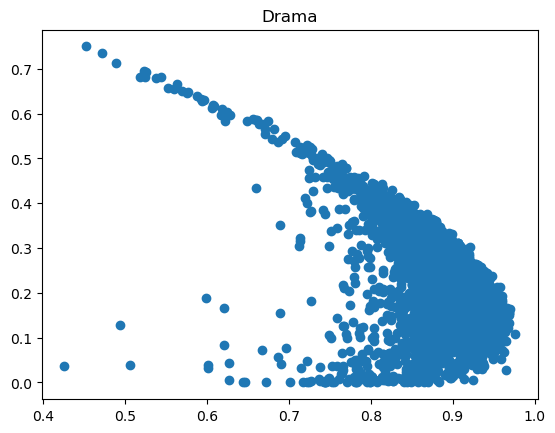

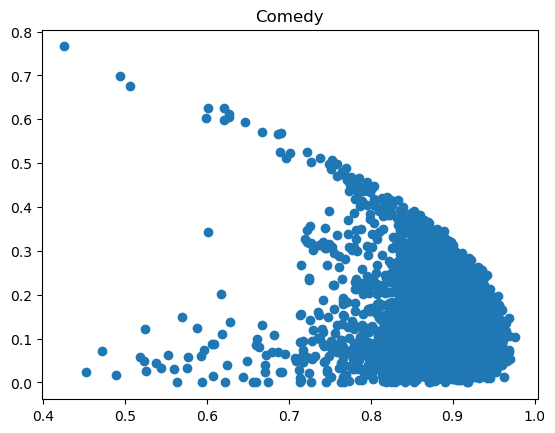

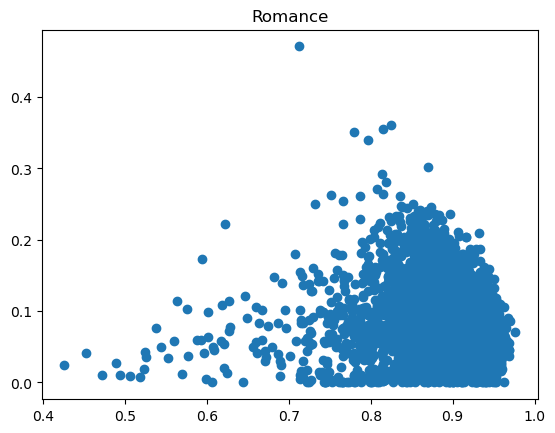

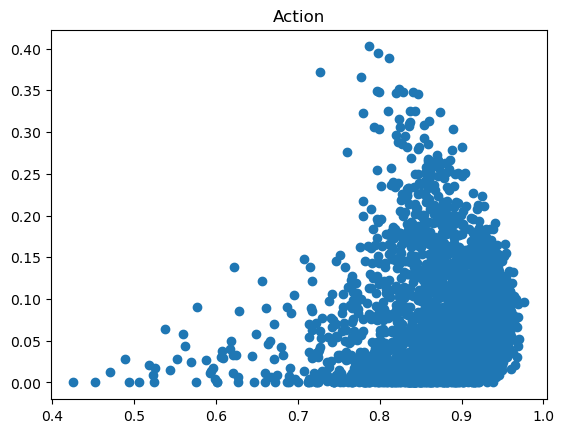

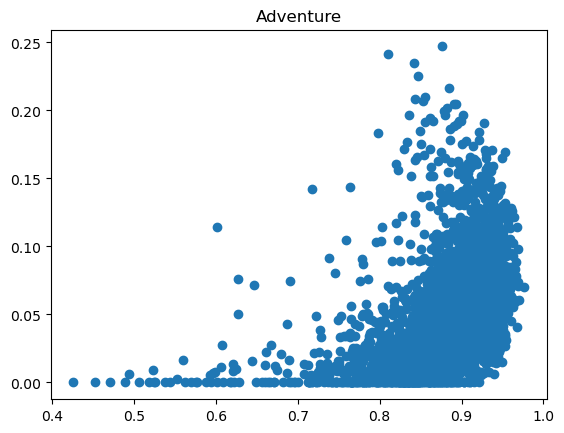

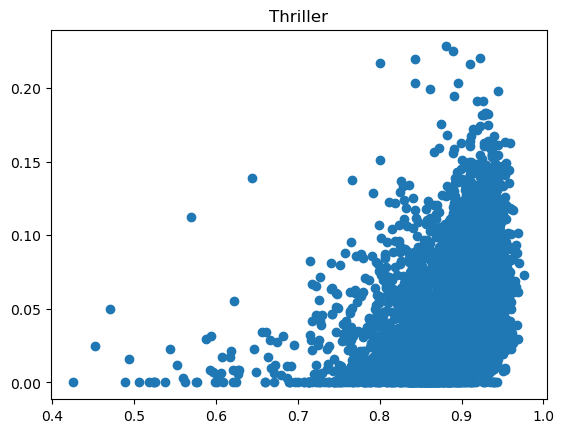

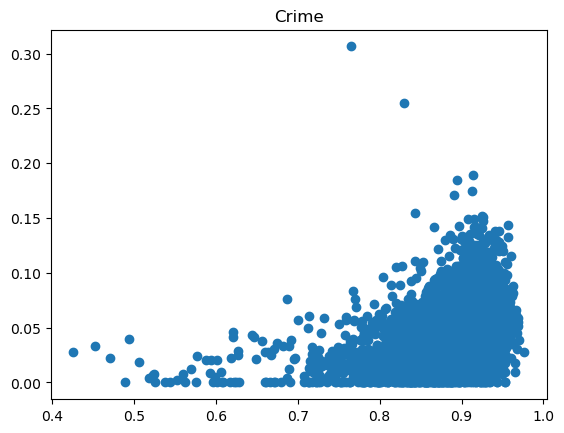

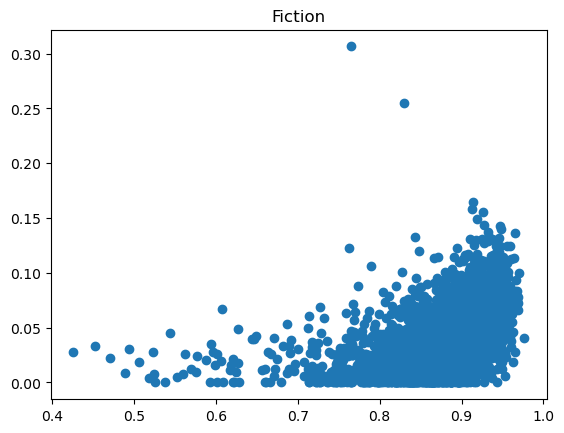

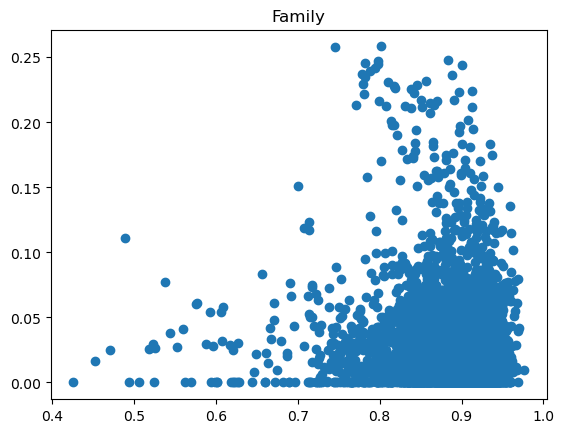

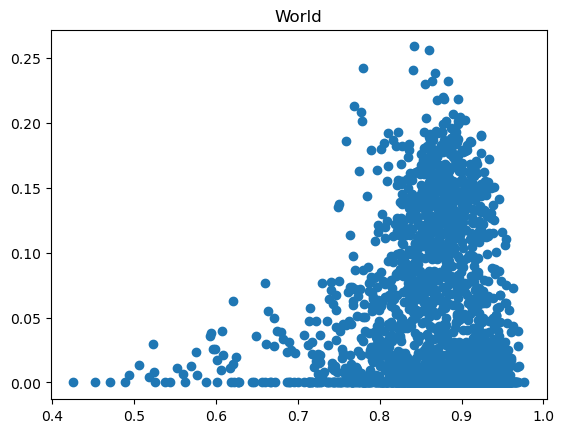

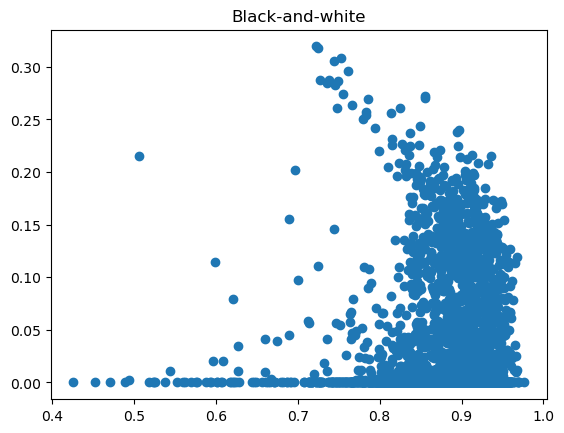

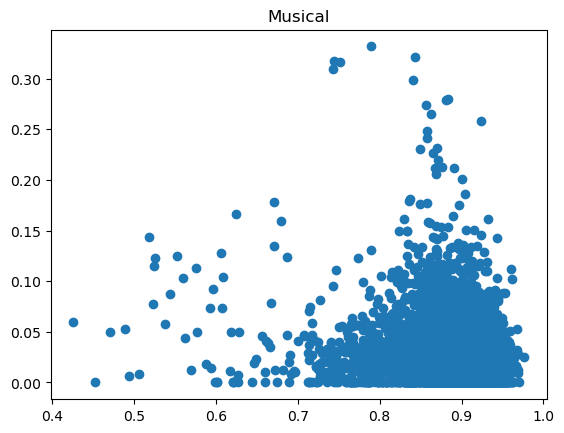

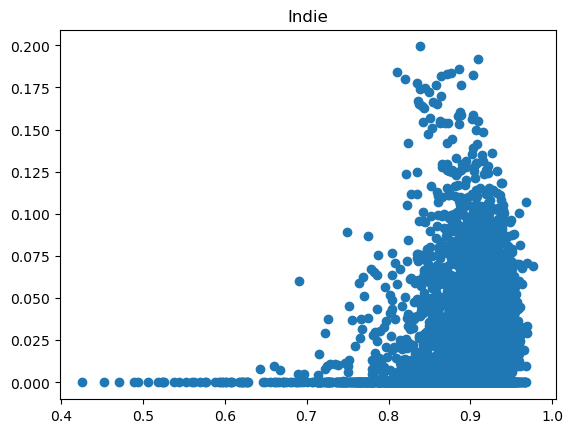

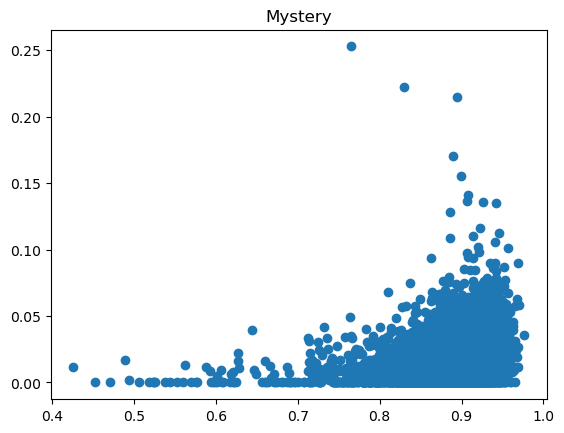

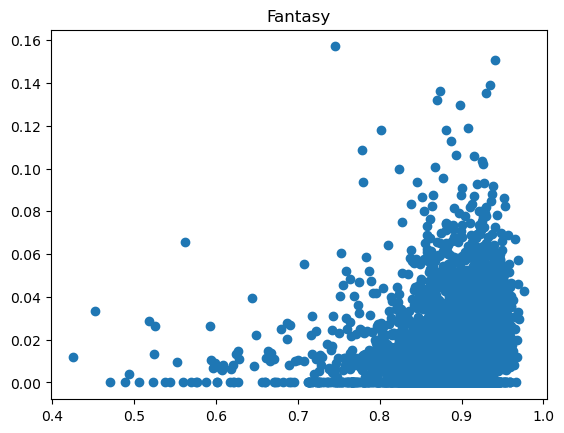

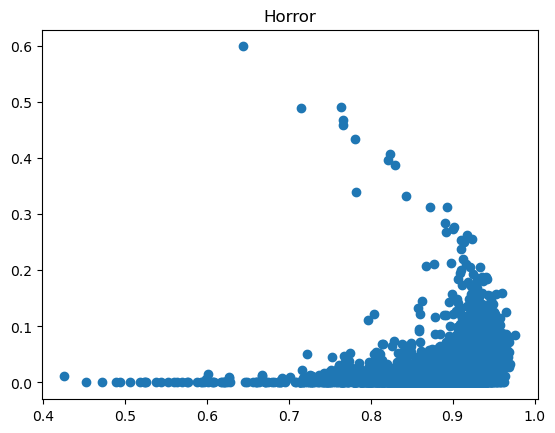

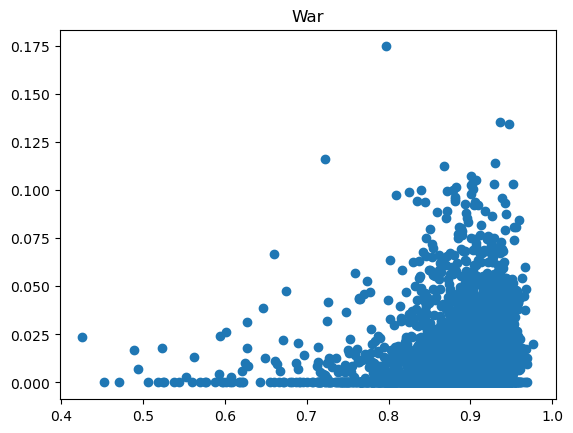

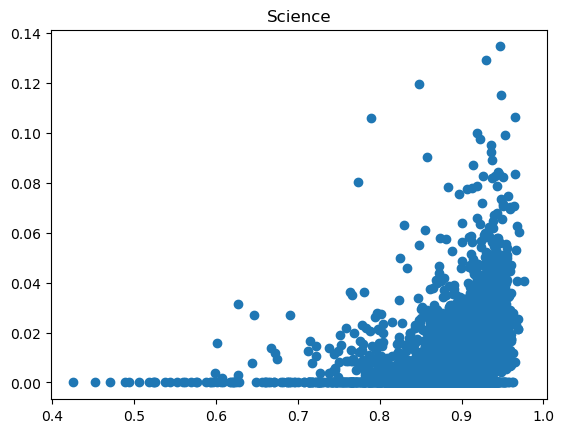

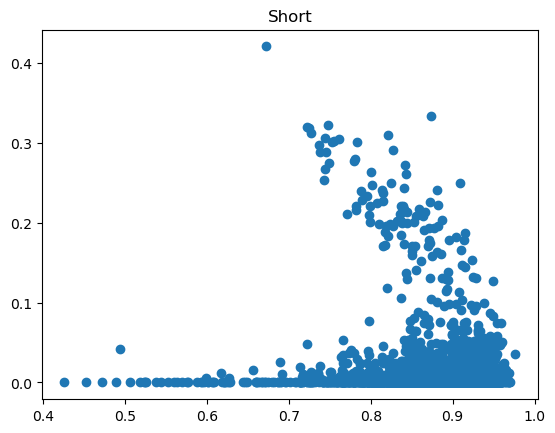

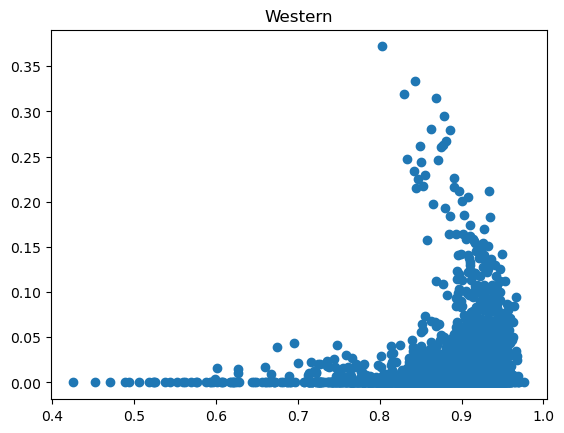

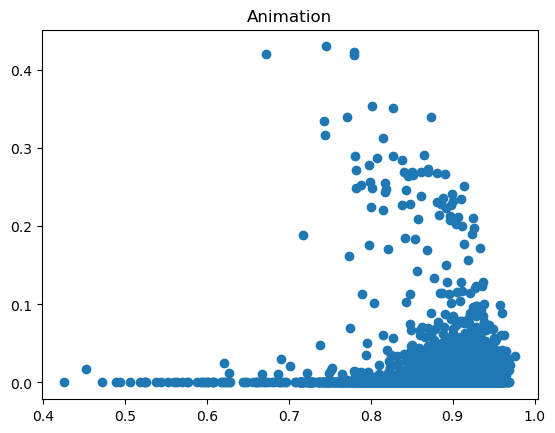

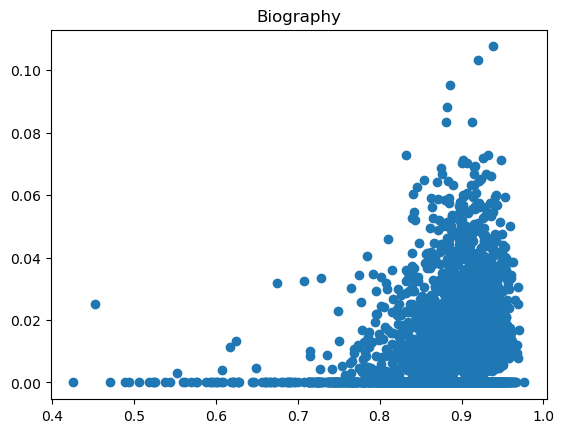

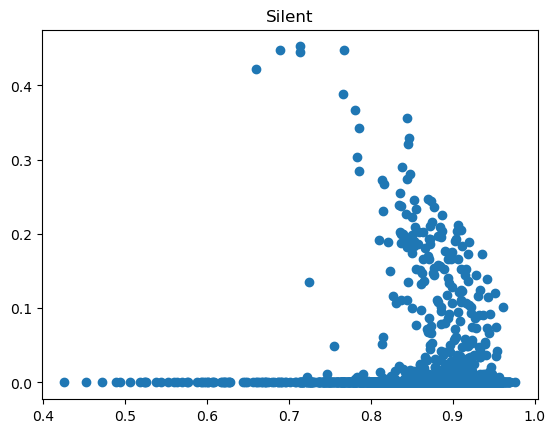

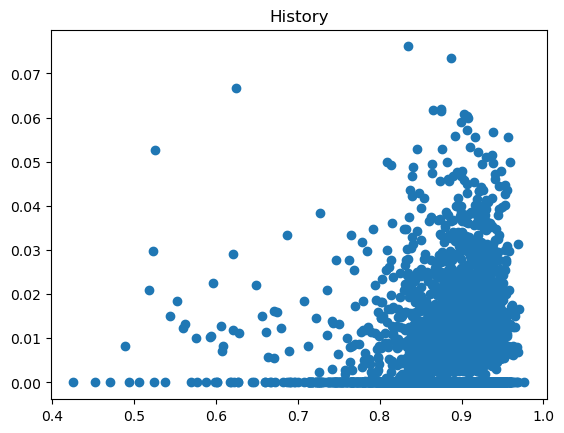

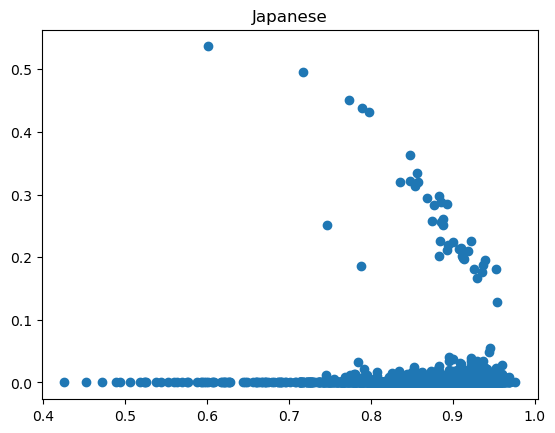

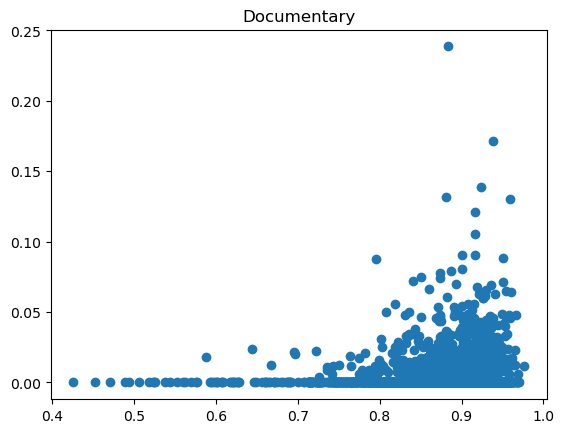

In [739]:
for col in actor_genre_percentage.columns:
    print(col, scipy.stats.pearsonr(actor_genre_percentage[col], NHHI))
    plt.figure()
    plt.scatter(NHHI,actor_genre_percentage[col])
    plt.title(col)

# NHHI EVOLUTION

In [470]:
actors_movies = actors_exp.merge(
    movies[["fbID", "genres", "releaseMonth", "releaseYear"]], how="left", on="fbID"
)
actors_sort = actors_movies.sort_values(
    by=["fbActorID", "ageAtMovieRelease", "releaseYear", "releaseMonth"]
)
actors_sort = actors_sort[
    ~(actors_sort.ageAtMovieRelease.isna() & actors_sort.releaseYear.isna())
    & ~actors_sort.genres.isna()
]

actors_sort["genresLen"] = actors_sort.genres.apply(lambda x: len(x))
actors_sort["LastMovie"] = np.array(
    [
        *(
            actors_sort.fbActorID[1:].values
            != actors_sort.fbActorID.values[:-1]
        ),
        True,
    ]
)
exploded_actors_genres = actors_sort.explode("genres")

In [469]:
#actors_sort.groupby(["fbActorID", "ageAtMovieRelease"]).agg({"genres": lambda x: list(x)})

genres
fbActorID ageAtMovieRelease                                                   
/m/010p3  33.0                                             [{Comedy, Romance}]
          34.0                                             [{Comedy, Romance}]
          35.0               [{Comedy, Romance, Drama}, {Comedy, Indie, Rom...
          38.0                                                      [{Comedy}]
          42.0                                      [{Comedy, Indie, Romance}]
...                                                                        ...
/m/0zcbl  43.0               [{Comedy, Drama}, {Comedy, Family, Indie, Dram...
          44.0               [{Thriller, Drama}, {Comedy, Thriller, Fiction...
          45.0                             [{Comedy, Musical, Romance, Drama}]
          46.0                       [{Comedy, Adventure, Animation}, {Drama}]
/m/0zjpz  49.0                             [{Biography, Musical, Documentary}]

[208056 rows x 1 columns]

In [ ]:
# Creating dummy variables for genres and counting occurrences for each actor and movie
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "ageAtMovieRelease", "genres", "fbID"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

In [458]:
# Creating dummy variables for genres and counting occurrences for each actor and movie
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "genres", "genresLen", "fbID"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

genre_dummies[genreslist] = (1 * genre_dummies[genreslist]).div(
    genre_dummies["genresLen"], axis=0
)

genre_dummies

,fbActorID,genresLen,fbID,Action,Adventure,Animation,Biography,Black-and-white,Comedy,Crime,...,Musical,Mystery,Romance,Science,Short,Silent,Thriller,War,Western,World
3,/m/010p3,2,/m/06c5z_,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/m/010p3,2,/m/06c5z_,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,/m/010p3,2,/m/0b6jfrc,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,/m/010p3,2,/m/0b6jfrc,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,/m/010p3,3,/m/08hjr9,0.0,0.0,0.000000,0.000000,0.0,0.333333,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446020,/m/0zcbl,3,/m/0gkyxjc,0.0,0.0,0.333333,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446023,/m/0zcbl,1,/m/0k3lpxc,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446027,/m/0zjpz,3,/m/05sqdmg,0.0,0.0,0.000000,0.333333,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446027,/m/0zjpz,3,/m/05sqdmg,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [277]:
genre_actor_len = (
    actors_min_movies.explode("genres")
    .groupby("fbActorID")[["genres", "numMovies"]]
    .aggregate(
        {"genres": (lambda x: (len(set(x)))), "numMovies": (lambda x: int(np.mean(x)))}
    )
)

In [278]:
mod = smf.ols(formula='numMovies ~  genres', data=genre_actor_len)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              numMovies   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     230.6
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.27e-50
Time:                        11:14:42   Log-Likelihood:                -17667.
No. Observations:                3869   AIC:                         3.534e+04
Df Residuals:                    3867   BIC:                         3.535e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1562      1.953      4.176      0.0

In [279]:
scipy.stats.pearsonr(genre_actor_len.genres,genre_actor_len.numMovies)

PearsonRResult(statistic=0.23720516348821924, pvalue=1.2667334225440596e-50)

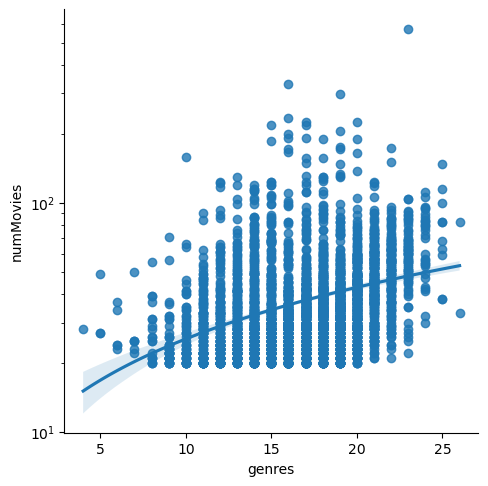

In [280]:
sns.lmplot(genre_actor_len, x="genres", y="numMovies")
plt.yscale("log")